# Identification des motifs de divorce par expressions régulières

In [54]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
from regex_utils import RegexEval
import preprocess_func

## Prototytpe à partir des motifs identifiés manuellement

In [55]:
path_causes_divorces = os.path.join("../data/annotation_manuelle/cause_divorce", "regex_causes_divorces.csv")

In [56]:
# Chargement données prototypes
df = pd.read_csv(path_causes_divorces, sep=";")

On a identifié ici quelques motifs récurrents :
* Faute :
    * article 242, articles 242 et suivants
    * torts de l'époux, torts du mari, torts exclusifs, torts partagés, torts réciproques
    * violation grave ou renouvelée
* Divorce accepté :
    * article 233, article 234
    * pour acceptation ... rupture du mariage
    * principe ... rupture ... mariage
    * acceptation
* Par altération définitive du lien conjugal :
    * article 237, article 238
    * altération définitive ... conjugal
    * lien conjugal ... altéré
* Consentement mutuel :
    * consentement mutuel

### Pour faute

In [57]:
faute = re.compile(("(?<!lorsque le divorce est prononcé)(?<!une demande reconventionnelle en divorce)(?<!les dépens le divorce étant prononcé)(?<!reconventionnellement le prononcé du divorce) aux torts (exclusif(s)?)? ?de?|"
"(?<!effets d'un divorce)(?<!une demande reconventionnelle en divorce)(?<!les dépens le divorce étant prononcé) aux torts partagés|"
"torts réciproques|"
"à leurs torts partagés|"
"violation grave ou renouvelée"))

# "article.*? 242|" => Trop d'overmatch
# https://regex101.com/r/w2asvP/1

### Divorce accepté

A partir des quelques tests effectués, on peut noter :
* L'article 234 seul apparaît quelque fois

In [58]:
divorce_accepte = re.compile((
"article 233|"
"article. 233|"
"(?<!lorsqu).+?prononce.+?pour.+?acceptation|"
"(?<!lorsqu).+?accept.+?rupture.+?mariage|"
"(?<!lorsqu)accord.+?principe.+?rupture|"
"(?<!lorsqu)accord.+?principe.+?divorce"
))

### Pour altération définitive du lien conjugal

In [59]:
alteration = re.compile(
"article.*? 23[78]"
)

### Séparation de corps

In [60]:
separation = re.compile(
"article 306|séparation .*? corps"
)

### Par consentement mutuel

In [61]:
consentement = re.compile(
"consentement mutuel"
)

## Evaluation des expressions régulières

A l'aide de quelques fonctions, on peut évaluer la sensibilité et la spécificité des expressions régulières définies plus haut.

In [62]:
regexp = {
    "Divorce accepté": divorce_accepte,
    "Pour altération définitive du lien conjugal": alteration,
    "Faute": faute,
    "Par conversion de séparation de corps": separation,
    "Consentement mutuel": consentement
}

## Analyse des résultats

In [63]:
# Function to order results in a table
def table_results(total, dict_per, dict_n):
    return pd.DataFrame({"True positives": [dict_per["TP"], dict_n["TP"]],
                         "False negatives": [dict_per["FN"], dict_n["FN"]],
                         "Total": [100, total]}, index=pd.Index(["%", "N"]))

In [64]:
regex_eval = RegexEval(regexp)

On applique l'évaluation des expressions régulières sur chaque type de cause de divorce.

Pour cela, il nous faut construire un tableau qui contienne :
* L'identifiant unique du document
* Le plein text
* Le type de divorce
* Le label du dictionnaire dans lequel on renseigne chaque expression régulière

In [65]:
for label in regexp.keys():
    for idx, row in df.iterrows():
        regex_eval.regex(doc_id=row["id"],
                         text=row["texte"],
                         label=row["type"],
                         exp=label)

On peut exporter individuellement chaque résultat dans un tableau.

In [66]:
regex_eval.export_results()

Enfin, on peut visualiser le ratio sensibilité/spécificité à l'aide d'une matrice de confusion.

### Pour faute

* `VERSAILLES 08-03034` : erreur de codage, devrait être **"divorce pour faute"**

In [67]:
total, results = regex_eval.calculate_metrics("Faute")
total, n = regex_eval.calculate_metrics("Faute", percentage=False)

In [68]:
table_results(total, results, n)

,True positives,False negatives,Total
%,94.186047,5.813953,100
N,81.000000,5.000000,86


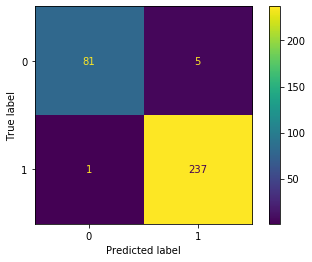

In [69]:
regex_eval.plot_confusion_matrix("Faute")

### Divorce accepté

In [70]:
total, results = regex_eval.calculate_metrics("Divorce accepté")
total, n = regex_eval.calculate_metrics("Divorce accepté", percentage=False)

In [71]:
table_results(total, results, n)

,True positives,False negatives,Total
%,90.625,9.375,100
N,116.000,12.000,128


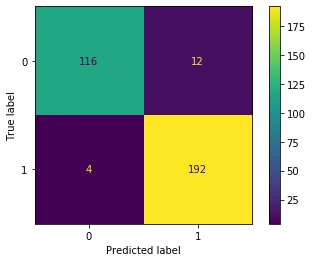

In [72]:
regex_eval.plot_confusion_matrix("Divorce accepté")

### Pour altération définitive du lien conjugal

In [73]:
total, results = regex_eval.calculate_metrics("Pour altération définitive du lien conjugal")
total, n = regex_eval.calculate_metrics("Pour altération définitive du lien conjugal", percentage=False)

In [74]:
table_results(total, results, n)

,True positives,False negatives,Total
%,42.574257,57.425743,100
N,43.000000,58.000000,101


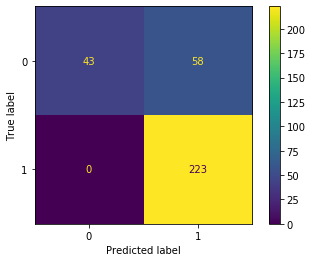

In [75]:
regex_eval.plot_confusion_matrix("Pour altération définitive du lien conjugal")

Le corpus prototypes compte 101 documents qui enregistrent un divorce pour cause d'"altération définitive du lien conjugal".

La mention des articles 237 ou 239 suffit pour identifier relativement précisément les divorces pour "altération définitive du lien conjugal".

### Séparation de corps

In [76]:
total, results = regex_eval.calculate_metrics("Par conversion de séparation de corps")
total, n = regex_eval.calculate_metrics("Par conversion de séparation de corps", percentage=False)

table_results(total, results, n)

,True positives,False negatives,Total
%,100.0,0.0,100
N,6.0,0.0,6


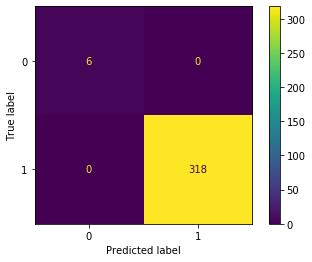

In [77]:
regex_eval.plot_confusion_matrix("Par conversion de séparation de corps")

### Par consentement mutuel

In [78]:
total, results = regex_eval.calculate_metrics("Consentement mutuel")
total, n = regex_eval.calculate_metrics("Consentement mutuel", percentage=False)

In [79]:
table_results(total, results, n)

,True positives,False negatives,Total
%,100.0,0.0,100
N,1.0,0.0,1


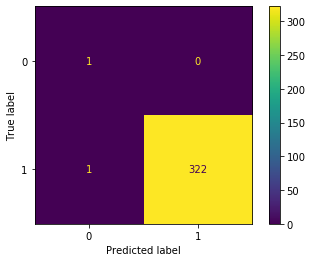

In [80]:
regex_eval.plot_confusion_matrix("Consentement mutuel")

## Test sur le corpus complet

In [81]:
# Chargement données COMPRES
df_compres = pd.read_csv(os.path.join("../data/tables", "compres.csv"))

C:\Users\RomainM\Anaconda3\envs\data_science\lib\site-packages\IPython\core\interactiveshell.py:3156: DtypeWarning: Columns (324,325,339,340,433,434,435,462,464,617) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


A partir des données contenues dans le tableau COMPRES et le corpus complet des textes, on peut tenter à présenter d'évaluer les expressions régulières sur un jeu plus important.

Dans le tableau COMPRES, la colonne `DIV_DMDE` contient les informations sur le type de divorce de chaque document.

On peut définir une fonction permettant de récupérer cette information qui est codée sous la forme suivante :
* `1` : Consentement mutuel
* `2` : Divorce accepté
* `3` : Faute
* `4` : Altération définitive du lien conjugal
* `5` : Par conversion de séparation de corps
* `6` : Autre
* `7` : Non renseigné

In [82]:
def get_divorce_type(df_compres, fname):
    divorce_type = df_compres[df_compres["id"] == fname]["DIV_DMDE"].item()
    if divorce_type == 1:
        return "Consentement mutuel"
    elif divorce_type == 2:
        return "Divorce accepté"
    elif divorce_type == 3:
        return "Faute"
    elif divorce_type == 4:
        return "Pour altération définitive du lien conjugal"
    elif divorce_type == 5:
        return "Par conversion de séparation de corps"
    elif divorce_type == 6:
        return "Autre"
    elif divorce_type == 7:
        return "Non renseigné"
    else:
        return None

Dans cette boucle, on reconstruit un tableau qui permet d'associer les données COMPRES avec le text intégral.

In [83]:
path_to_texts = "../data/texts"
list_metadata = []

for file in os.listdir(path_to_texts):
    if file.endswith(".txt"):
        with open(os.path.join(path_to_texts, file), "r", encoding="utf-8") as text:
            f = text.read()
            metadata = {"id": file[:-4],
                        "type": get_divorce_type(df_compres=df_compres, fname=file[:-4]),
                        "texte": f}
        list_metadata.append(metadata)

In [84]:
df_fulltext = pd.DataFrame(list_metadata)

A partir du tableau sur le texte intégral, on peut évaluer les expressions régulières sur un corpus plus large.

In [85]:
regex_eval = RegexEval(regexp)

In [86]:
df_fulltext["type"].unique()

array(['Pour altération définitive du lien conjugal', 'Divorce accepté',
       'Faute', 'Par conversion de séparation de corps', None, 'Autre'],
      dtype=object)

In [87]:
for label in regexp.keys():
    for idx, row in df_fulltext.iterrows():
        regex_eval.regex(doc_id=row["id"],
                         text=row["texte"],
                         label=row["type"],
                         exp=label)

In [88]:
regex_eval.export_results()

### Pour faute

In [89]:
total, results = regex_eval.calculate_metrics("Faute")
total, n = regex_eval.calculate_metrics("Faute", percentage=False)

In [90]:
table_results(total, results, n)

,True positives,False negatives,Total
%,98.333333,1.666667,100
N,472.000000,8.000000,480


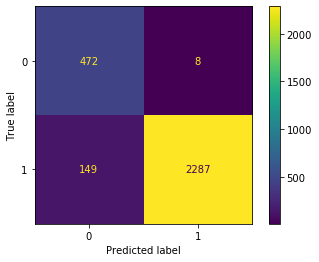

In [91]:
regex_eval.plot_confusion_matrix("Faute")

On arrive à bien identifier les **divorces pour faute** à l'aide d'expressions régulières avec une bonne sensibilité (seulement **5 cas non identifiés**), mais une mauvaise spécificité.

### Divorce accepté

In [92]:
total, results = regex_eval.calculate_metrics("Divorce accepté")
total, n = regex_eval.calculate_metrics("Divorce accepté", percentage=False)

In [93]:
table_results(total, results, n)

,True positives,False negatives,Total
%,99.303797,0.696203,100
N,1569.000000,11.000000,1580


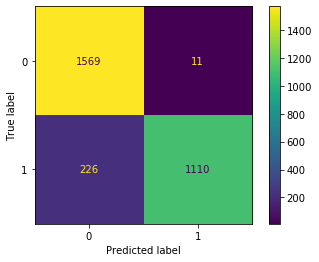

In [94]:
regex_eval.plot_confusion_matrix("Divorce accepté")

### Pour altération définitive du lien conjugal

In [95]:
total, results = regex_eval.calculate_metrics("Pour altération définitive du lien conjugal")
total, n = regex_eval.calculate_metrics("Pour altération définitive du lien conjugal", percentage=False)

In [96]:
table_results(total, results, n)

,True positives,False negatives,Total
%,98.527607,1.472393,100
N,803.000000,12.000000,815


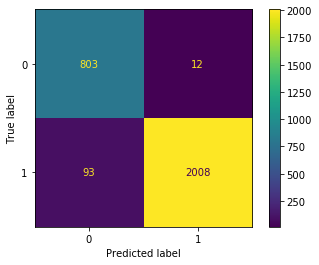

In [97]:
regex_eval.plot_confusion_matrix("Pour altération définitive du lien conjugal")

Le corpus prototypes compte 101 documents qui enregistrent un divorce pour cause d'"altération définitive du lien conjugal".

La mention des articles 237 ou 239 suffit pour identifier relativement précisément les divorces pour "altération définitive du lien conjugal".

### Séparation de corps

In [98]:
total, results = regex_eval.calculate_metrics("Par conversion de séparation de corps")
total, n = regex_eval.calculate_metrics("Par conversion de séparation de corps", percentage=False)

table_results(total, results, n)

,True positives,False negatives,Total
%,100.0,0.0,100
N,22.0,0.0,22


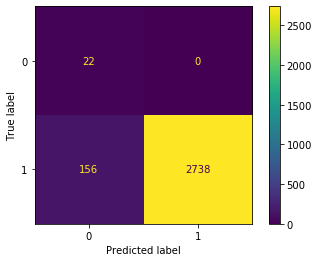

In [99]:
regex_eval.plot_confusion_matrix("Par conversion de séparation de corps")

### Par consentement mutuel

In [100]:
total, results = regex_eval.calculate_metrics("Consentement mutuel")
total, n = regex_eval.calculate_metrics("Consentement mutuel", percentage=False)

ZeroDivisionError: division by zero

In [ ]:
table_results(total, results, n)

In [ ]:
regex_eval.plot_confusion_matrix("Consentement mutuel")

## Capture en deux temps

### Pour faute

In [ ]:
faute = re.compile(("(?<!lorsqu).+?aux torts (exclusif(s)?)? ?de?|"
"(?<!lorsqu).+?aux torts (exclusif(s)?)? ?du mari|"
"torts réciproques|"
"aux torts partagés|"
"à leurs torts partagés|"
"violation grave ou renouvelée|"
"aux torts .+ divorce"))

In [ ]:
def is_matched(text, sec_filter, divorce_type, window=40):
    regex_res = re.search(faute, text)
    try:
        if sec_filter in text[regex_res.span()[0] - window:regex_res.span()[1] + window]:
            return "FALSE POSITIVE", regex_res
        else:
            return divorce_type, regex_res
    except AttributeError:
        return "TRUE NEGATIVE", None

In [ ]:
df_fulltext.columns

In [ ]:
TP = 0
FP = 0
TN = 0

for i, row in df_fulltext.iterrows():
    div_type, res_capt_regex = is_matched(text=row["texte"], sec_filter="lorsqu", divorce_type=row["type"])
    if div_type == row["type"]:
        TP += 1
    elif div_type == "FALSE POSITIVE":
        FP += 1
    elif div_type == "TRUE NEGATIVE":
        TN += 1

In [ ]:
TP

In [ ]:
FP

In [ ]:
TN